In [ ]:
import pandas as pd
import numpy as np
import requests
import zipfile
from google.colab import files
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
uploaded = files.upload()

Saving winequality-red.csv to winequality-red.csv


In [ ]:
redwine = pd.read_csv('winequality-red.csv', sep = ';')
# Read the CSV file into a DataFrame

# View the first five rows of the DataFrame
redwine.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [ ]:
X = redwine.drop('quality', axis=1)  # Features
y = redwine['quality']               # Target

# Split the dataset: 70% training, 15% validation, and 15% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) # 70% training
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # 15% validation, 15% testing

# scaling features
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [ ]:
def train_linear_regression(X, y):
  """
  Trains a simple linear regression model using the closed-form solution.

  Args:
    X: A NumPy array of shape (n_samples, n_features) representing the features.
    y: A NumPy array of shape (n_samples,) representing the target variable.

  Returns:
    w: A NumPy array of shape (n_features,) representing the learned coefficients.
  """
  # bias term
  X_bias = np.c_[np.ones(X.shape[0]), X]

  # closed form solution w = (X^TX)^(-1)X^Ty
  X_transpose = X_bias.T
  w = np.linalg.inv(X_transpose @ X_bias) @ X_transpose @ y

  return w

def predict(X, w):
    """
    Predicts the target variable using the learned coefficients.

    Args:
      X: A NumPy array of shape (n_samples, n_features) representing the features.
      w: A NumPy array of shape (n_features,) representing the learned coefficients.
    """
    X_bias = np.c_[np.ones(X.shape[0]), X]
    y_pred = X_bias @ w
    return y_pred


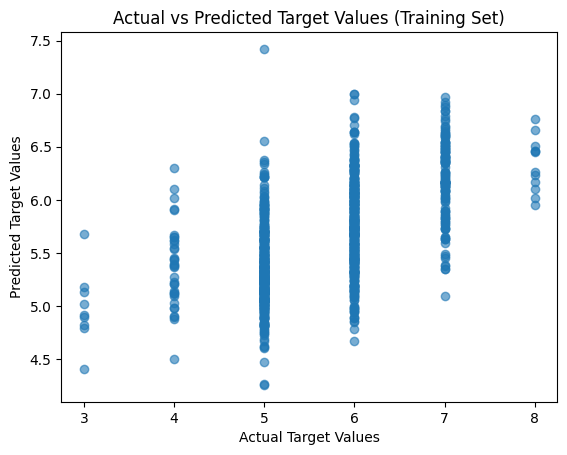

In [ ]:
weights = train_linear_regression(X_train, y_train)
y_train_pred = predict(X_train, weights)

plt.scatter(y_train, y_train_pred, alpha=0.6)
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Actual vs Predicted Target Values (Training Set)')
plt.show()

We can see that the linear regression model is performing badly, as there is clusters of points at each quality level and the spread within each vertical cluster varies widely. In addition, this quality prediction problem can be interpreted as a multi-class classification, and hence linear regression model is not the best option in handling categorical target

In [ ]:
def rmse(y_actual, y_pred):
    """

    Calculates the Root Mean Squared Error (RMSE) between the actual and predicted values.
    Args:
      y_actual: A NumPy array of shape (n_samples,) representing the actual target values.
      y_pred: A NumPy array of shape (n_samples,) representing the predicted target values.

    Returns:
      rmse: A float representing the RMSE value.
    """
    mse = np.mean((y_actual - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

In [ ]:
y_test_pred = predict(X_test, weights)
rmse_train = rmse(y_train, y_train_pred)
rmse_test = rmse(y_test, y_test_pred)
print(f"RMSE on training set: {rmse_train}")
print(f"RMSE on test set: {rmse_test}")

RMSE on training set: 0.6486806989670354
RMSE on test set: 0.6450840357212348


In [ ]:
def lms_linear_reg (X, y, learning_rate = 0.01, num_iterations = 1000):
  """
  Implement LMS algorithm for linear regression.

  Args:
    X: A NumPy array of shape (n_samples, n_features) representing the features.
    y: A NumPy array of shape (n_samples,) representing the target variable.
    learning_rate: A float representing the learning rate.
    num_iterations: An integer representing the number of iterations.

  Returns:
    w: A NumPy array of shape (n_features,) representing the learned coefficients.

  """
  X_bias = np.c_[np.ones(X.shape[0]), X]
  # randomly initialized weights
  np.random.seed(0)
  w = np.random.rand(X_bias.shape[1])


  for epoch in range(num_iterations):
        # Shuffle the data at the start of each epoch
        indices = np.random.permutation(X_bias.shape[0])
        X_bias_shuffled = X_bias[indices]
        y_shuffled = y.iloc[indices]

        # Loop over each sample in the shuffled dataset
        for i in range(X_bias.shape[0]):
            X_i = X_bias_shuffled[i, :]
            y_i = y_shuffled.iloc[i]

            # Compute the prediction
            y_pred_i = np.dot(X_i, w)

            # Compute the error
            error_i = y_i - y_pred_i

            # Update the weights
            w += learning_rate * error_i * X_i

  return w

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
results = []

for lr in learning_rates:
    # Train the model using the current learning rate
    weights_lms = lms_linear_reg(X_train, y_train, learning_rate=lr, num_iterations=1000)

    # Predict on the training and test sets
    y_train_pred = predict(X_train, weights_lms)
    y_val_pred = predict(X_val, weights_lms)

    # Calculate RMSE for the training and test sets
    rmse_train = rmse(y_train, y_train_pred)
    rmse_val = rmse(y_val, y_val_pred)

    # Store the results
    results.append((lr, rmse_train, rmse_val))

    # Print the results for the current learning rate
    print(f"Learning Rate: {lr}, Training RMSE: {rmse_train}, Validation RMSE: {rmse_val}")

Learning Rate: 0.01, Training RMSE: 0.6675686882006028, Validation RMSE: 0.6439179476294145
Learning Rate: 0.001, Training RMSE: 0.6490304342609168, Validation RMSE: 0.6396162131490196
Learning Rate: 0.0001, Training RMSE: 0.6486827882119091, Validation RMSE: 0.6376773239191673


We can see that as learning rate decreases, the error decreases as well. Hence, in this case, we would choose `lr = 0.0001` as the learning rate since it has the lowest validation error.